In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

import xgboost as xgb
import optuna
import warnings
import pickle
from tqdm import tqdm


warnings.filterwarnings('ignore')

Be advised:
- if this code is run in its entirety, it will trigger the Optuna searches, which can potentially crash the device if it does not have sufficient memory
- the Optuna searches can take at least 1 hour and a half to run. However, this depends on the system's specifications
- the pkl files will be generated in the same directory as the existing file

In [4]:
# Set display options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Load the dataset
dataset_path = r"C:\Users\USER\Desktop\Thesis\data\cleaned data\cleaned_marketing_campaign_dataset.csv"
df = pd.read_csv(dataset_path)

# Function to create campaign segments based on media_cost
def create_campaign_segments(cost):
    if cost < 1:
        return 'micro-budget'
    elif cost < 10:
        return 'small'
    elif cost < 100:
        return 'medium'
    else:
        return 'large'

# Function to create nonlinear features
def create_nonlinear_features(X_df):
    """
    Create nonlinear transformations of features
    """
    X_nonlinear = X_df.copy()
    
    # Only apply transformations to numerical features
    numerical_cols = X_df.select_dtypes(include=['int64', 'float64']).columns
    
    for col in numerical_cols:
        # Add squared terms
        X_nonlinear[f'{col}_squared'] = X_df[col] ** 2
        
        # Add log transformations (adding 1 to handle zeros)
        X_nonlinear[f'{col}_log'] = np.log1p(X_df[col])
        
        # Add square root transformation
        X_nonlinear[f'{col}_sqrt'] = np.sqrt(X_df[col])
        
    # Add interaction terms between numerical features
    for i, col1 in enumerate(numerical_cols):
        for col2 in numerical_cols[i+1:]:
            X_nonlinear[f'{col1}_x_{col2}'] = X_df[col1] * X_df[col2]
    
    return X_nonlinear

# Function to create preprocessing pipeline with nonlinear features
def create_preprocessor(X, categorical_features, include_nonlinear=True, polynomial_degree=2):
    """
    Create a preprocessing pipeline for categorical and numerical features
    with optional nonlinear transformations
    """
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Define preprocessing for numerical features
    numeric_features = [col for col in X.columns if col not in categorical_features]
    
    if include_nonlinear:
        numeric_transformer = Pipeline(steps=[
            ('poly', PolynomialFeatures(degree=polynomial_degree, include_bias=False)),
            ('scaler', StandardScaler())
        ])
    else:
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())
        ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    return preprocessor

def add_conversion_constraints_to_training(X, y, actual_clicks_col='clicks'):
    """
    Add constraints to the conversion model training to ensure proper relationships
    between clicks and impressions
    
    Parameters:
    -----------
    X : DataFrame
        Features dataframe
    y : Series
        Target series (log-transformed impressions)
    actual_clicks_col : str
        Name of the column with actual click data
        
    Returns:
    --------
    X : DataFrame
        Features dataframe with constraints
    y : Series
        Target series with constraints
    sample_weight : ndarray
        Sample weights for training
    """
    # Create a copy to avoid modifying originals
    X_constrained = X.copy()
    y_constrained = y.copy()
    
    # Get actual clicks data from the dataset
    actual_clicks = np.log1p(X_constrained[actual_clicks_col]) if actual_clicks_col in X_constrained.columns else None
    
    if actual_clicks is not None:
        # Create sample weights - give more importance to samples where impressions > clicks
        # Log-transformed data means y > actual_clicks is equivalent to impressions > clicks
        sample_weight = np.ones(len(y_constrained))
        
        # Identify problematic samples (where impressions ≤ clicks)
        problematic_idx = y_constrained <= actual_clicks
        
        if problematic_idx.any():
            print(f"Found {problematic_idx.sum()} samples where impressions ≤ clicks")
            
            # Create a minimum threshold (impressions should be at least 10% more than clicks)
            min_impressions_log = actual_clicks + np.log(1.1)
            
            # Adjust target values for problematic samples
            y_constrained[problematic_idx] = min_impressions_log[problematic_idx]
            
            # Give higher weight to these adjusted samples to emphasize the constraint
            sample_weight[problematic_idx] = 2.0
            
            print(f"Adjusted {problematic_idx.sum()} samples to enforce impressions > clicks constraint")
    else:
        sample_weight = None
        print("Warning: Click data not found in features, cannot add impression-click constraints")
    
    return X_constrained, y_constrained, sample_weight


# Optuna objective function with nonlinear features
def objective(trial, X_train, y_train, X_val, y_val, categorical_features, campaign_type=None, sample_weight=None):
    """
    Objective function for Optuna hyperparameter tuning
    """
    # Decide whether to include nonlinear features
    include_nonlinear = trial.suggest_categorical('include_nonlinear', [True, False])
    
    # If using nonlinear features, determine polynomial degree
    if include_nonlinear:
        polynomial_degree = trial.suggest_int('polynomial_degree', 2, 3)
    else:
        polynomial_degree = 2  # Dummy value, won't be used
    
    # Create preprocessing pipeline
    preprocessor = create_preprocessor(X_train, categorical_features, 
                                      include_nonlinear=include_nonlinear,
                                      polynomial_degree=polynomial_degree)
    
    # Define hyperparameters to optimize
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5.0),
    }
    
    # Decide on loss function (Huber loss can help with outliers)
    loss_function = trial.suggest_categorical('loss_function', 
                                             ['reg:squarederror', 'reg:pseudohubererror'])
    
    # Create XGBoost model
    xgb_model = xgb.XGBRegressor(
        objective=loss_function,
        **param,
        random_state=42,
        n_jobs=-1
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb_model)
    ])
    
    # Train the model (with sample weights if provided)
    if sample_weight is not None and campaign_type == 'conversion':
        # Apply preprocessor separately so we can use sample weights
        X_train_processed = preprocessor.fit_transform(X_train)
        xgb_model.fit(X_train_processed, y_train, sample_weight=sample_weight)
        pipeline.named_steps['preprocessor'] = preprocessor
        pipeline.named_steps['regressor'] = xgb_model
    else:
        pipeline.fit(X_train, y_train)
    
    # Predict on validation data
    y_pred = pipeline.predict(X_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    return rmse

# Function to train best model
def train_best_model(X_train, y_train, best_params, categorical_features):
    """
    Train model with best parameters
    """
    # Extract parameters for preprocessing
    include_nonlinear = best_params.pop('include_nonlinear', False)
    polynomial_degree = best_params.pop('polynomial_degree', 2)
    loss_function = best_params.pop('loss_function', 'reg:squarederror')
    
    # Create preprocessing pipeline
    preprocessor = create_preprocessor(X_train, categorical_features, 
                                      include_nonlinear=include_nonlinear,
                                      polynomial_degree=polynomial_degree)
    
    # Create XGBoost model with best parameters
    xgb_model = xgb.XGBRegressor(
        objective=loss_function,
        **best_params,
        random_state=42,
        n_jobs=-1
    )
    
    # Create pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb_model)
    ])
    
    # Train the model
    model.fit(X_train, y_train)
    
    return model

# Function to evaluate model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model on test data
    """
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Calculate MAPE (handling zeros in the target)
    y_true = y_test.values
    non_zero_idx = y_true != 0
    if non_zero_idx.sum() > 0:
        mape = mean_absolute_percentage_error(y_true[non_zero_idx], y_pred[non_zero_idx]) * 100
    else:
        mape = np.nan
    
    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAPE (%)': mape
    }
    
    return metrics, y_pred

# Function to preprocess data
def preprocess_data(data, campaign_type):
    """
    Preprocess the data based on the campaign type
    """
    # Create a copy to avoid modifying the original data
    df_processed = data.copy()
    
    # Apply log transformation to media_cost if not already present
    if 'log_media_cost' not in df_processed.columns:
        df_processed['log_media_cost'] = np.log1p(df_processed['media_cost_usd'])
    
    # Create campaign segments if not already present
    if 'campaign_segment' not in df_processed.columns:
        df_processed['campaign_segment'] = df_processed['media_cost_usd'].apply(create_campaign_segments)
    
    # Create nonlinear features for all models
    df_processed['log_media_cost_squared'] = df_processed['log_media_cost'] ** 2
    df_processed['log_duration'] = np.log1p(df_processed['duration'])
    df_processed['duration_squared'] = df_processed['duration'] ** 2
    df_processed['log_media_cost_x_duration'] = df_processed['log_media_cost'] * df_processed['duration']
    
    # Define all features to use
    feature_columns = [
        'log_media_cost', 
        'duration', 
        'ext_service_name', 
        'campaign_segment',
        'log_media_cost_squared',
        'log_duration',
        'duration_squared',
        'log_media_cost_x_duration'
    ]
    
    # Define target based on campaign type
    if campaign_type == 'awareness':
        target = 'clicks'
    elif campaign_type == 'conversion':
        target = 'impressions'
    
    # Log-transform the target
    log_target = np.log1p(df_processed[target])
    
    # Select features and target
    X = df_processed[feature_columns]
    y = log_target
    
    # Always use log-transformed target
    use_log_target = True
    print(f"Using log-transformed {target} as target")
    
    return X, y, df_processed, use_log_target

# Function to manually plot Optuna results with Matplotlib
def plot_optuna_results(study, title):
    """
    Plot Optuna optimization history and parameter importance
    """
    # Extract study data
    trials_df = study.trials_dataframe()
    
    # Plot optimization history
    plt.figure(figsize=(10, 6))
    plt.plot(trials_df['number'], trials_df['value'], 'o-')
    plt.xlabel('Trial Number')
    plt.ylabel('RMSE (lower is better)')
    plt.title(f'Optimization History - {title}')
    plt.grid(True)
    plt.show()
    
    # Calculate parameter importance
    param_importance = {}
    params = study.best_trial.params.keys()
    for param in params:
        # Skip non-numeric parameters for correlation calculation
        if param in ['include_nonlinear', 'loss_function']:
            continue
            
        try:
            values = trials_df[f'params_{param}'].values
            scores = trials_df['value'].values
            
            # Calculate correlation between parameter and objective
            correlation = np.corrcoef(values, scores)[0, 1]
            param_importance[param] = abs(correlation)  # Use absolute correlation as importance
        except:
            # Skip if correlation can't be calculated
            pass
    
    # Convert to DataFrame and sort
    importance_df = pd.DataFrame({
        'Parameter': list(param_importance.keys()),
        'Importance': list(param_importance.values())
    }).sort_values('Importance', ascending=False)
    
    # Plot parameter importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Parameter', data=importance_df)
    plt.title(f'Parameter Importance - {title}')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Main Optuna execution function
def run_modeling_with_optuna(campaign_type, n_trials=50):
    """
    Run the modeling process with Optuna hyperparameter optimization and constraints
    """
    print(f"\n{'='*80}\nStarting modeling for {campaign_type.upper()} campaigns\n{'='*80}")
    
    # Preprocess data with nonlinear transformations
    X, y, processed_data, use_log_target = preprocess_data(df, campaign_type)
    
    # Define categorical features
    categorical_features = ['ext_service_name', 'campaign_segment']
    
    # For conversion models, add constraints to ensure impressions > clicks
    sample_weight = None
    if campaign_type == 'conversion':
        # Add 'clicks' column to features if not already present
        if 'clicks' not in X.columns and 'clicks' in df.columns:
            X['clicks'] = df['clicks']
        
        # Apply constraints
        X, y, sample_weight = add_conversion_constraints_to_training(X, y)
    
    # Split data into train, validation, and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)
    
    # Split sample weights if they exist
    if sample_weight is not None:
        train_val_idx = np.arange(len(X))[~np.isin(np.arange(len(X)), np.arange(len(X_test)))]
        train_idx = np.arange(len(X_train_val))[~np.isin(np.arange(len(X_train_val)), np.arange(len(X_val)))]
        
        sample_weight_train_val = sample_weight[train_val_idx]
        sample_weight_train = sample_weight_train_val[train_idx]
    else:
        sample_weight_train = None
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Run Optuna hyperparameter optimization
    print(f"Starting Optuna hyperparameter optimization with {n_trials} trials...")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val, 
                                           categorical_features, campaign_type, sample_weight_train), 
                  n_trials=n_trials)
    
    # Get best parameters
    best_params = study.best_params
    print(f"Best parameters: {best_params}")
    print(f"Best RMSE: {study.best_value:.4f}")
    
    # Train model with best parameters
    print("Training final model with best parameters...")
    best_model = train_best_model(X_train_val, y_train_val, best_params.copy(), categorical_features)
    
    # Evaluate model
    metrics, y_pred = evaluate_model(best_model, X_test, y_test)
    print("\nModel evaluation metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # If we used log-transformed target, we need to transform predictions back
    if use_log_target:
        # Original test values
        y_test_original = np.expm1(y_test)
        # Transform predictions back
        y_pred_original = np.expm1(y_pred)
        
        # Calculate metrics on original scale
        mse_original = mean_squared_error(y_test_original, y_pred_original)
        rmse_original = np.sqrt(mse_original)
        r2_original = r2_score(y_test_original, y_pred_original)
        
        # Calculate MAPE on original scale
        non_zero_idx = y_test_original.values != 0
        if non_zero_idx.sum() > 0:
            mape_original = mean_absolute_percentage_error(
                y_test_original.values[non_zero_idx], 
                y_pred_original[non_zero_idx]) * 100
        else:
            mape_original = np.nan
        
        metrics_original = {
            'MSE (original scale)': mse_original,
            'RMSE (original scale)': rmse_original,
            'R2 (original scale)': r2_original,
            'MAPE (%) (original scale)': mape_original
        }
        
        print("\nModel evaluation metrics (original scale):")
        for metric, value in metrics_original.items():
            print(f"{metric}: {value:.4f}")
        
        # Plot actual vs predicted on original scale
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test_original, y_pred_original, alpha=0.5)
        plt.plot([y_test_original.min(), y_test_original.max()], 
                [y_test_original.min(), y_test_original.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted (Original Scale) - {campaign_type.capitalize()}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        # Plot actual vs predicted
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title(f'Actual vs Predicted - {campaign_type.capitalize()}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    # Plot error distribution
    if use_log_target:
        errors = y_test_original - y_pred_original
    else:
        errors = y_test - y_pred
        
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=30)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution - {campaign_type.capitalize()}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot Optuna results
    plot_optuna_results(study, campaign_type.capitalize())
    
    # Save model and transformation info
    model_data = {
        'model': best_model,
        'use_log_target': use_log_target,
        'best_params': best_params
    }
    
    model_name = f"xgboost_{campaign_type}_nonlinear_model.pkl"
    print(f"Saving model {model_name}...")
    with open(model_name, 'wb') as f:
        pickle.dump(model_data, f)
    
    return model_data, metrics, study

# Function to predict using the trained model
def predict_campaign_metrics(model_data, media_cost, duration, platform):
    """
    Predict campaign metrics using trained model
    """
    # Extract model and transformation info
    model = model_data['model']
    use_log_target = model_data['use_log_target']
    
    # Create campaign segment
    segment = create_campaign_segments(media_cost)
    
    # Apply log transformation to media_cost
    log_media_cost = np.log1p(media_cost)
    
    # Create all the nonlinear features that were used in training
    log_media_cost_squared = log_media_cost ** 2
    log_duration = np.log1p(duration)
    duration_squared = duration ** 2
    log_media_cost_x_duration = log_media_cost * duration
    
    # Create input data with exactly the same features used in training
    input_data = pd.DataFrame({
        'log_media_cost': [log_media_cost],
        'duration': [duration],
        'ext_service_name': [platform],
        'campaign_segment': [segment],
        'log_media_cost_squared': [log_media_cost_squared],
        'log_duration': [log_duration],
        'duration_squared': [duration_squared],
        'log_media_cost_x_duration': [log_media_cost_x_duration]
    })
    
    # Check if all columns needed by the model are in the input data
    model_features = model.named_steps['preprocessor'].transformers_[0][2]
    model_features += model.named_steps['preprocessor'].transformers_[1][2]
    missing_cols = set(model_features) - set(input_data.columns)
    
    if missing_cols:
        raise ValueError(f"columns are missing: {missing_cols}")
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    
    # Transform prediction back if log-transformed target was used
    if use_log_target:
        prediction = np.expm1(prediction)
    
    # Ensure non-negative prediction
    prediction = max(0, prediction)
    
    return prediction

Models loaded successfully
Generating test scenarios...
Generated 90 test scenarios
Evaluating models on scenarios...


Evaluating scenarios: 100%|██████████| 90/90 [00:00<00:00, 92.94it/s]


Analyzing results...


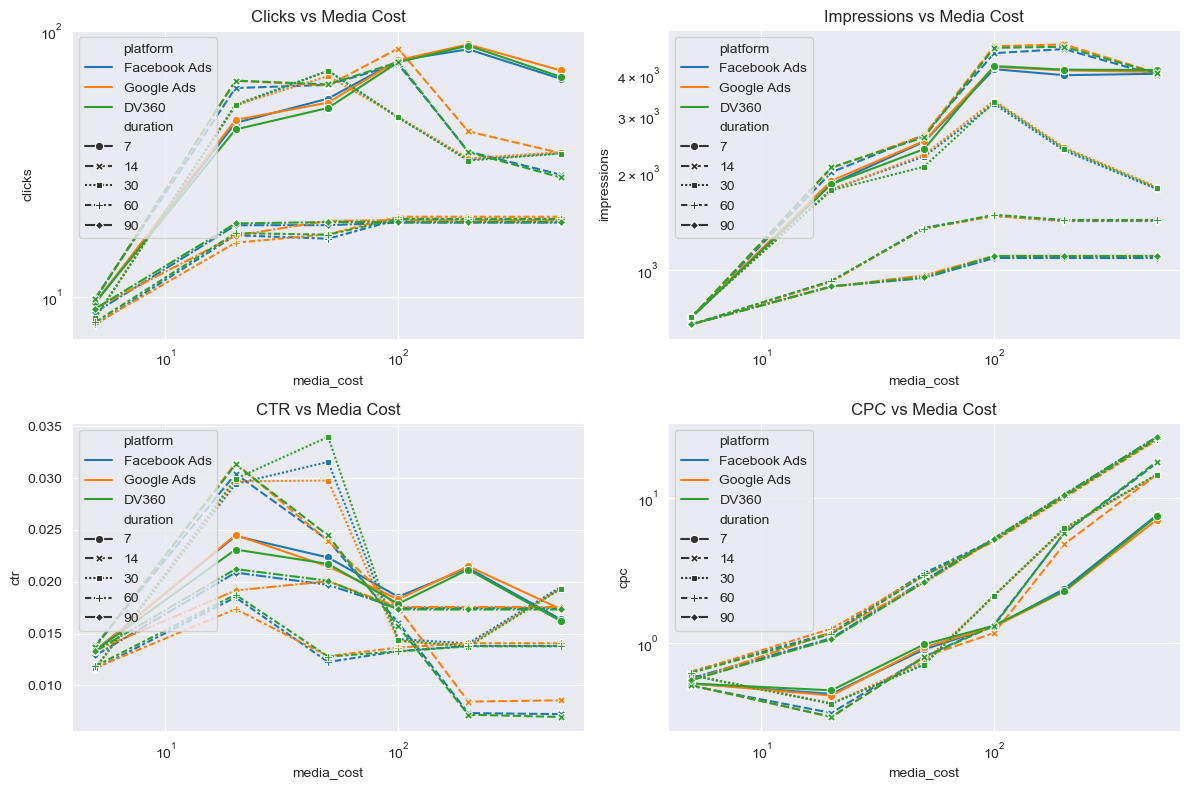

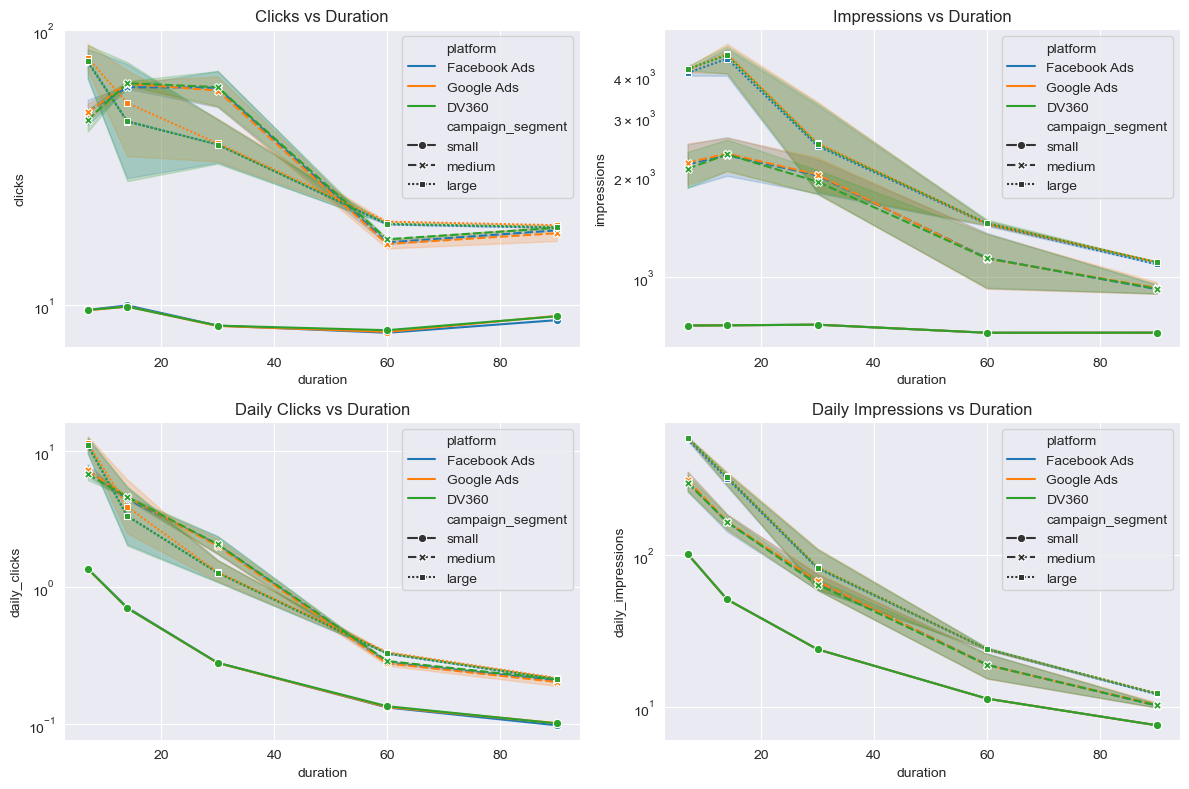

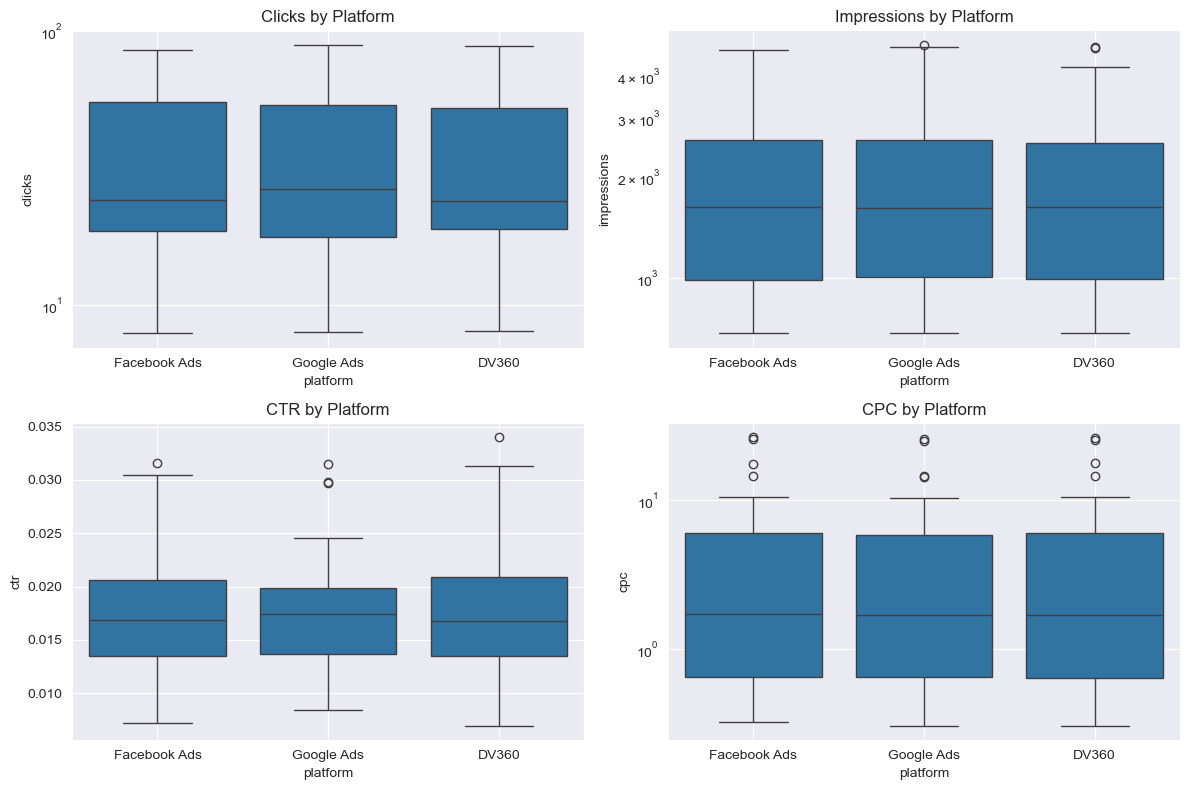

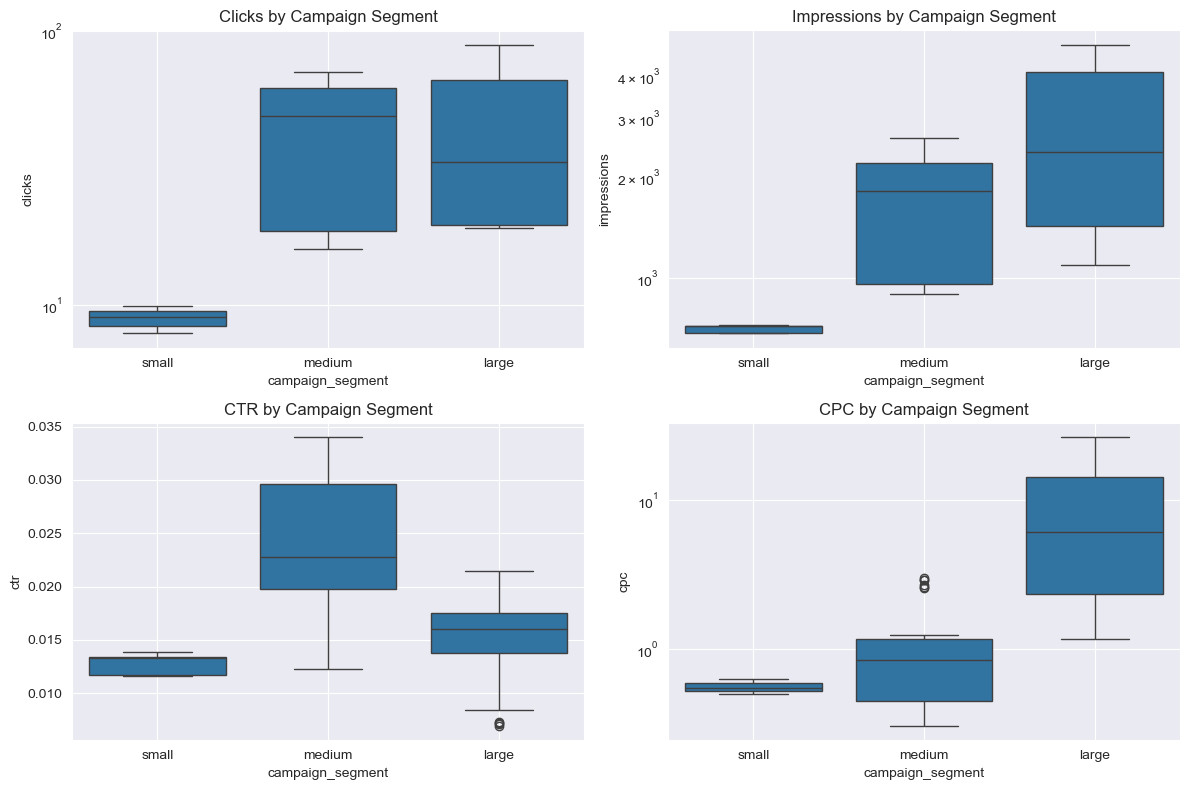


Summary Statistics:
                     clicks                                              impressions                                                           ctr                                               cpc                                                  cpm                                              
                       mean     median        std        min        max         mean       median          std          min          max      mean    median       std       min       max      mean    median       std       min        max        mean     median         std        min         max
campaign_segment                                                                                                                                                                                                                                                                                       
large             40.814861  33.219688  24.418629  19.060621  89.017601  2752.080322  2372.

Comparing with actual data: 100%|██████████| 90/90 [00:00<00:00, 101.32it/s]



Overall Metrics:
clicks_mse_mean: 729.6414
clicks_rmse_mean: 14.5312
clicks_r2_mean: nan
clicks_mape_mean: 19.8774
impressions_mse_mean: 235154.7759
impressions_rmse_mean: 347.5367
impressions_r2_mean: nan
impressions_mape_mean: 15.7303


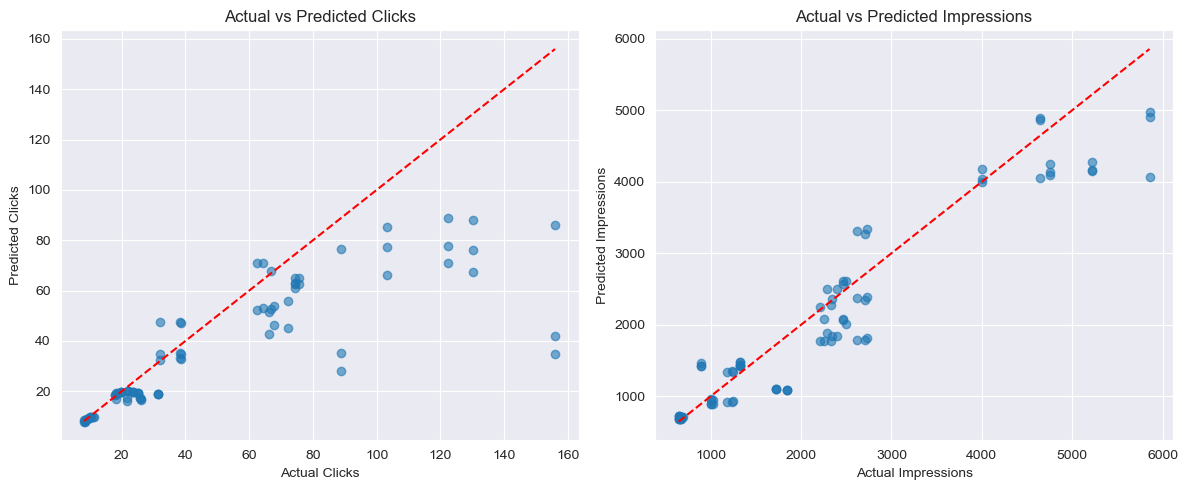

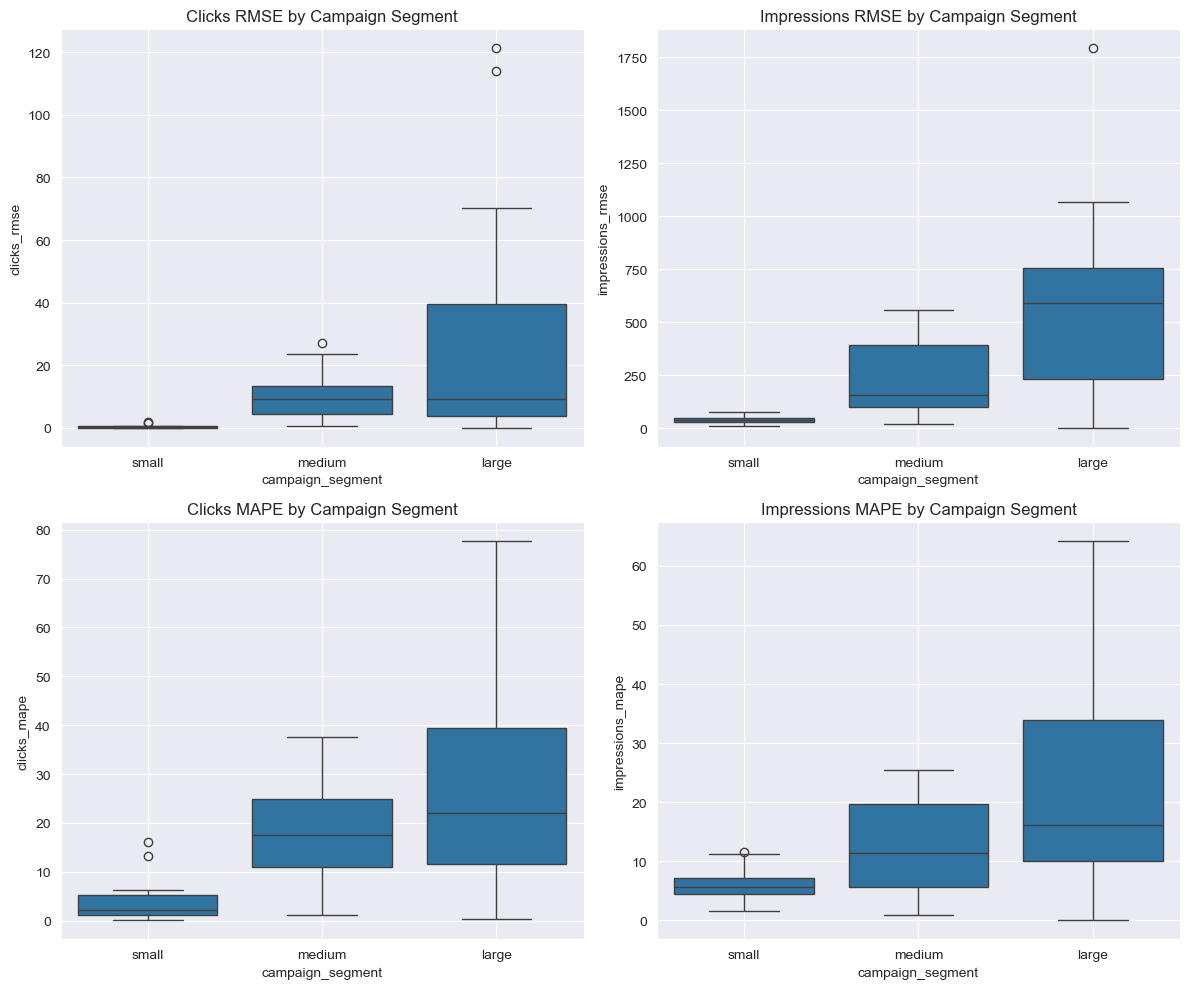

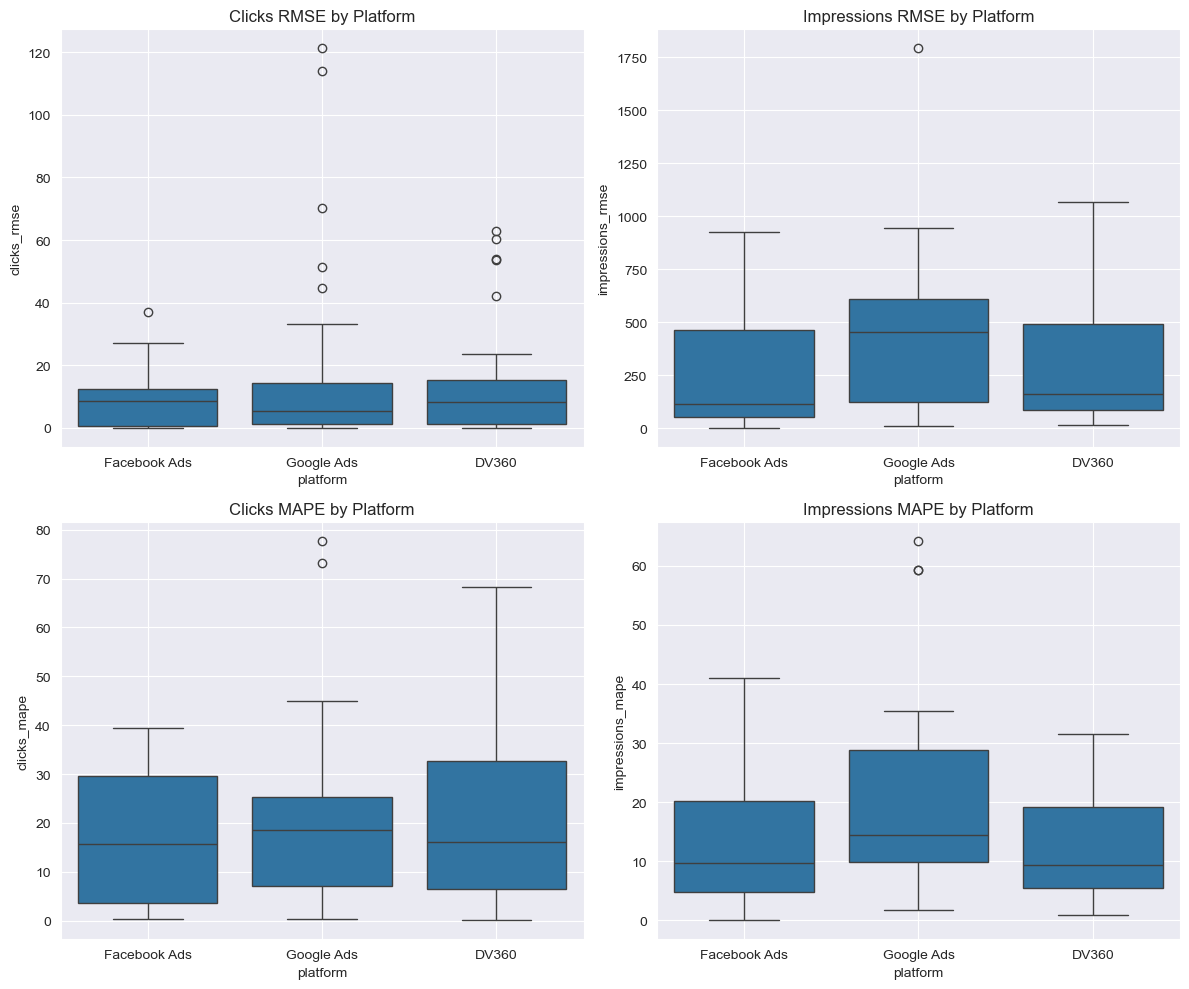

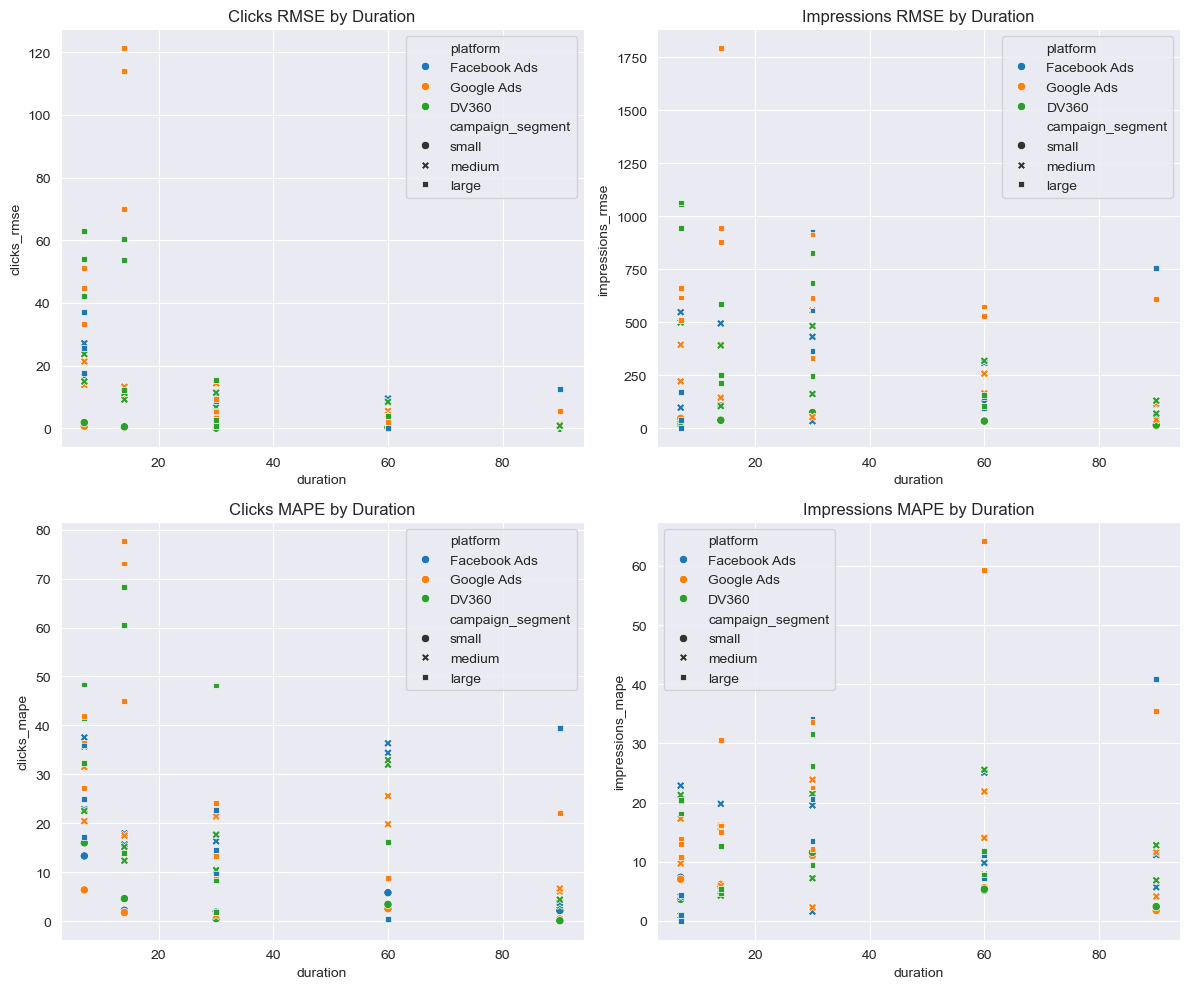


Metrics exported to 'model_evaluation_metrics.csv'

Comprehensive testing completed!


In [5]:
def load_models():
    """
    Load the trained nonlinear models
    
    Returns:
    --------
    models: dict
        Dictionary containing both awareness and conversion models
    """
    models = {}
    
    try:
        # Load awareness model
        with open("xgboost_awareness_nonlinear_model.pkl", 'rb') as f:
            models['awareness'] = pickle.load(f)
        
        # Load conversion model
        with open("xgboost_conversion_nonlinear_model.pkl", 'rb') as f:
            models['conversion'] = pickle.load(f)
        
        print("Models loaded successfully")
        return models
    
    except FileNotFoundError as e:
        print(f"Error loading models: {e}")
        print("Please ensure the model files exist in the current directory")
        return None

def create_campaign_segments(cost):
    """Create campaign segments based on media cost"""
    if cost < 1:
        return 'micro-budget'
    elif cost < 10:
        return 'small'
    elif cost < 100:
        return 'medium'
    else:
        return 'large'

def predict_campaign_metrics(model_data, media_cost, duration, platform, clicks=None):
    """
    Predict campaign metrics using trained model with post-processing constraints
    
    Parameters:
    -----------
    model_data: dict
        Dictionary containing model and transformation information
    media_cost: float
        Media cost in USD
    duration: int
        Campaign duration in days
    platform: str
        Advertising platform ('facebook', 'google', 'dv360')
    clicks: float, optional
        Number of clicks (for conversion model only)
        
    Returns:
    --------
    prediction: float
        Predicted value (clicks or impressions)
    """
    # Extract model and transformation info
    model = model_data['model']
    use_log_target = model_data['use_log_target']
    
    # Create campaign segment
    segment = create_campaign_segments(media_cost)
    
    # Apply log transformation to media_cost
    log_media_cost = np.log1p(media_cost)
    
    # Create all the nonlinear features that were used in training
    log_media_cost_squared = log_media_cost ** 2
    log_duration = np.log1p(duration)
    duration_squared = duration ** 2
    log_media_cost_x_duration = log_media_cost * duration
    
    # Create input data with exactly the same features used in training
    input_data = pd.DataFrame({
        'log_media_cost': [log_media_cost],
        'duration': [duration],
        'ext_service_name': [platform],
        'campaign_segment': [segment],
        'log_media_cost_squared': [log_media_cost_squared],
        'log_duration': [log_duration],
        'duration_squared': [duration_squared],
        'log_media_cost_x_duration': [log_media_cost_x_duration]
    })
    
    # Make prediction
    prediction = model.predict(input_data)[0]
    
    # Transform prediction back if log-transformed target was used
    if use_log_target:
        prediction = np.expm1(prediction)
    
    # Ensure non-negative prediction
    prediction = max(0, prediction)
    
    # For conversion model predictions (impressions), ensure they're greater than clicks
    if clicks is not None:
        # This is a conversion model predicting impressions
        if prediction <= clicks:
            # If prediction is less than or equal to clicks, enforce a minimum CTR threshold
            # Use a reasonable CTR threshold (10-20% depending on platform)
            if platform == 'facebook':
                min_ctr = 0.02  # 2% CTR for Facebook
            elif platform == 'google':
                min_ctr = 0.03  # 3% CTR for Google
            else:  # dv360
                min_ctr = 0.015  # 1.5% CTR for DV360
                
            # Ensure impressions are at least 1/min_ctr times clicks
            min_impressions = clicks / min_ctr
            prediction = max(prediction, min_impressions)
            
            print(f"Warning: Adjusted predicted impressions from {prediction:.0f} to {min_impressions:.0f} to enforce realistic CTR")
    
    return prediction

def generate_test_scenarios():
    """
    Generate a range of test scenarios to evaluate model performance
    
    Returns:
    --------
    scenarios: list
        List of dictionaries containing test scenarios
    """
    # Define parameter ranges for testing
    media_costs = [5, 20, 50, 100, 200, 500]
    durations = [7, 14, 30, 60, 90]
    platforms = ['Facebook Ads', 'Google Ads', 'DV360']
    
    # Generate all combinations
    scenarios = []
    for cost, dur, plat in itertools.product(media_costs, durations, platforms):
        scenarios.append({
            'media_cost': cost,
            'duration': dur,
            'platform': plat
        })
    
    return scenarios

def evaluate_models_on_scenarios(models, scenarios):
    """
    Evaluate models on test scenarios
    
    Parameters:
    -----------
    models: dict
        Dictionary containing awareness and conversion models
    scenarios: list
        List of dictionaries containing test scenarios
    
    Returns:
    --------
    results: pandas DataFrame
        DataFrame containing predictions for all scenarios
    """
    results = []
    
    for scenario in tqdm(scenarios, desc="Evaluating scenarios"):
        media_cost = scenario['media_cost']
        duration = scenario['duration']
        platform = scenario['platform']
        
        # Awareness model predicts clicks
        predicted_clicks = predict_campaign_metrics(
            models['awareness'],
            media_cost,
            duration,
            platform
        )
        
        # Conversion model predicts impressions
        predicted_impressions = predict_campaign_metrics(
            models['conversion'],
            media_cost,
            duration,
            platform
        )
        
        # Calculate derived metrics
        ctr = predicted_clicks / predicted_impressions if predicted_impressions > 0 else 0
        cpc = media_cost / predicted_clicks if predicted_clicks > 0 else float('inf')
        cpm = (media_cost / predicted_impressions) * 1000 if predicted_impressions > 0 else 0
        daily_cost = media_cost / duration
        daily_impressions = predicted_impressions / duration
        daily_clicks = predicted_clicks / duration
        
        # Store results
        results.append({
            'media_cost': media_cost,
            'duration': duration,
            'platform': platform,
            'campaign_segment': create_campaign_segments(media_cost),
            'clicks': predicted_clicks,
            'impressions': predicted_impressions,
            'ctr': ctr,
            'cpc': cpc,
            'cpm': cpm,
            'daily_cost': daily_cost,
            'daily_impressions': daily_impressions,
            'daily_clicks': daily_clicks
        })
    
    return pd.DataFrame(results)

def compare_with_actual_data(results_df, actual_data_path):
    """
    Compare model predictions with actual data
    
    Parameters:
    -----------
    results_df: pandas DataFrame
        DataFrame containing predictions for all scenarios
    actual_data_path: str
        Path to actual campaign data
        
    Returns:
    --------
    metrics_df: pandas DataFrame
        DataFrame containing evaluation metrics
    """
    # Load actual data
    try:
        actual_df = pd.read_csv(actual_data_path)
        print(f"Loaded actual data with {len(actual_df)} records")
    except Exception as e:
        print(f"Error loading actual data: {e}")
        return None
    
    # Preprocess actual data
    actual_df['campaign_segment'] = actual_df['media_cost_usd'].apply(create_campaign_segments)
    
    # Merge predicted and actual data based on similar parameters
    merged_data = []
    
    for _, pred_row in tqdm(results_df.iterrows(), desc="Comparing with actual data", total=len(results_df)):
        # Find similar campaigns in actual data
        similar_campaigns = actual_df[
            (actual_df['campaign_segment'] == pred_row['campaign_segment']) &
            (actual_df['ext_service_name'] == pred_row['platform']) &
            (actual_df['duration'].between(pred_row['duration'] * 0.8, pred_row['duration'] * 1.2))
        ]
        
        if len(similar_campaigns) > 0:
            # Calculate average actual values
            avg_actual_clicks = similar_campaigns['clicks'].mean()
            avg_actual_impressions = similar_campaigns['impressions'].mean()
            
            # Calculate metrics for awareness model (clicks)
            clicks_mse = mean_squared_error([avg_actual_clicks], [pred_row['clicks']])
            clicks_rmse = np.sqrt(clicks_mse)
            clicks_r2 = r2_score([avg_actual_clicks], [pred_row['clicks']]) if avg_actual_clicks != pred_row['clicks'] else 1.0
            
            if avg_actual_clicks > 0:
                clicks_mape = mean_absolute_percentage_error([avg_actual_clicks], [pred_row['clicks']]) * 100
            else:
                clicks_mape = np.nan
            
            # Calculate metrics for conversion model (impressions)
            impressions_mse = mean_squared_error([avg_actual_impressions], [pred_row['impressions']])
            impressions_rmse = np.sqrt(impressions_mse)
            impressions_r2 = r2_score([avg_actual_impressions], [pred_row['impressions']]) if avg_actual_impressions != pred_row['impressions'] else 1.0
            
            if avg_actual_impressions > 0:
                impressions_mape = mean_absolute_percentage_error([avg_actual_impressions], [pred_row['impressions']]) * 100
            else:
                impressions_mape = np.nan
            
            merged_data.append({
                'media_cost': pred_row['media_cost'],
                'duration': pred_row['duration'],
                'platform': pred_row['platform'],
                'campaign_segment': pred_row['campaign_segment'],
                'num_similar_campaigns': len(similar_campaigns),
                'predicted_clicks': pred_row['clicks'],
                'actual_clicks': avg_actual_clicks,
                'clicks_mse': clicks_mse,
                'clicks_rmse': clicks_rmse,
                'clicks_r2': clicks_r2,
                'clicks_mape': clicks_mape,
                'predicted_impressions': pred_row['impressions'],
                'actual_impressions': avg_actual_impressions,
                'impressions_mse': impressions_mse,
                'impressions_rmse': impressions_rmse,
                'impressions_r2': impressions_r2,
                'impressions_mape': impressions_mape
            })
    
    if not merged_data:
        print("No matching campaigns found in actual data")
        return None
    
    metrics_df = pd.DataFrame(merged_data)
    
    # Calculate overall metrics
    overall_metrics = {
        'clicks_mse_mean': metrics_df['clicks_mse'].mean(),
        'clicks_rmse_mean': metrics_df['clicks_rmse'].mean(),
        'clicks_r2_mean': metrics_df['clicks_r2'].mean(),
        'clicks_mape_mean': metrics_df['clicks_mape'].mean(),
        'impressions_mse_mean': metrics_df['impressions_mse'].mean(),
        'impressions_rmse_mean': metrics_df['impressions_rmse'].mean(),
        'impressions_r2_mean': metrics_df['impressions_r2'].mean(),
        'impressions_mape_mean': metrics_df['impressions_mape'].mean()
    }
    
    print("\nOverall Metrics:")
    for metric, value in overall_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    return metrics_df

def analyze_scenario_results(results_df):
    """
    Analyze and visualize model predictions across different scenarios
    
    Parameters:
    -----------
    results_df: pandas DataFrame
        DataFrame containing predictions for all scenarios
    """
    # 1. Analyze trends by media cost
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.lineplot(data=results_df, x='media_cost', y='clicks', hue='platform', style='duration', markers=True)
    plt.title('Clicks vs Media Cost')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.lineplot(data=results_df, x='media_cost', y='impressions', hue='platform', style='duration', markers=True)
    plt.title('Impressions vs Media Cost')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.lineplot(data=results_df, x='media_cost', y='ctr', hue='platform', style='duration', markers=True)
    plt.title('CTR vs Media Cost')
    plt.xscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.lineplot(data=results_df, x='media_cost', y='cpc', hue='platform', style='duration', markers=True)
    plt.title('CPC vs Media Cost')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('media_cost_analysis.png')
    plt.show()
    
    # 2. Analyze trends by duration
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.lineplot(data=results_df, x='duration', y='clicks', hue='platform', style='campaign_segment', markers=True)
    plt.title('Clicks vs Duration')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.lineplot(data=results_df, x='duration', y='impressions', hue='platform', style='campaign_segment', markers=True)
    plt.title('Impressions vs Duration')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.lineplot(data=results_df, x='duration', y='daily_clicks', hue='platform', style='campaign_segment', markers=True)
    plt.title('Daily Clicks vs Duration')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.lineplot(data=results_df, x='duration', y='daily_impressions', hue='platform', style='campaign_segment', markers=True)
    plt.title('Daily Impressions vs Duration')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('duration_analysis.png')
    plt.show()
    
    # 3. Platform comparison
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(data=results_df, x='platform', y='clicks')
    plt.title('Clicks by Platform')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=results_df, x='platform', y='impressions')
    plt.title('Impressions by Platform')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.boxplot(data=results_df, x='platform', y='ctr')
    plt.title('CTR by Platform')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=results_df, x='platform', y='cpc')
    plt.title('CPC by Platform')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('platform_analysis.png')
    plt.show()
    
    # 4. Campaign segment analysis
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(data=results_df, x='campaign_segment', y='clicks')
    plt.title('Clicks by Campaign Segment')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=results_df, x='campaign_segment', y='impressions')
    plt.title('Impressions by Campaign Segment')
    plt.yscale('log')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.boxplot(data=results_df, x='campaign_segment', y='ctr')
    plt.title('CTR by Campaign Segment')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=results_df, x='campaign_segment', y='cpc')
    plt.title('CPC by Campaign Segment')
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('segment_analysis.png')
    plt.show()
    
    # 5. Summary statistics
    print("\nSummary Statistics:")
    summary_stats = results_df.groupby('campaign_segment')[
        ['clicks', 'impressions', 'ctr', 'cpc', 'cpm']
    ].agg(['mean', 'median', 'std', 'min', 'max'])
    
    print(summary_stats)
    
    # 6. Export results to CSV
    results_df.to_csv('model_test_results.csv', index=False)
    print("\nResults exported to 'model_test_results.csv'")

def evaluate_with_actual_data(metrics_df):
    """
    Visualize model performance compared to actual data
    
    Parameters:
    -----------
    metrics_df: pandas DataFrame
        DataFrame containing evaluation metrics
    """
    if metrics_df is None:
        return
    
    # 1. Actual vs Predicted Plots
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(metrics_df['actual_clicks'], metrics_df['predicted_clicks'], alpha=0.6)
    plt.plot([metrics_df['actual_clicks'].min(), metrics_df['actual_clicks'].max()],
            [metrics_df['actual_clicks'].min(), metrics_df['actual_clicks'].max()], 'r--')
    plt.xlabel('Actual Clicks')
    plt.ylabel('Predicted Clicks')
    plt.title('Actual vs Predicted Clicks')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.scatter(metrics_df['actual_impressions'], metrics_df['predicted_impressions'], alpha=0.6)
    plt.plot([metrics_df['actual_impressions'].min(), metrics_df['actual_impressions'].max()],
            [metrics_df['actual_impressions'].min(), metrics_df['actual_impressions'].max()], 'r--')
    plt.xlabel('Actual Impressions')
    plt.ylabel('Predicted Impressions')
    plt.title('Actual vs Predicted Impressions')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('actual_vs_predicted.png')
    plt.show()
    
    # 2. Metrics by Campaign Segment
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(data=metrics_df, x='campaign_segment', y='clicks_rmse')
    plt.title('Clicks RMSE by Campaign Segment')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=metrics_df, x='campaign_segment', y='impressions_rmse')
    plt.title('Impressions RMSE by Campaign Segment')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.boxplot(data=metrics_df, x='campaign_segment', y='clicks_mape')
    plt.title('Clicks MAPE by Campaign Segment')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=metrics_df, x='campaign_segment', y='impressions_mape')
    plt.title('Impressions MAPE by Campaign Segment')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('metrics_by_segment.png')
    plt.show()
    
    # 3. Metrics by Platform
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    sns.boxplot(data=metrics_df, x='platform', y='clicks_rmse')
    plt.title('Clicks RMSE by Platform')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.boxplot(data=metrics_df, x='platform', y='impressions_rmse')
    plt.title('Impressions RMSE by Platform')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.boxplot(data=metrics_df, x='platform', y='clicks_mape')
    plt.title('Clicks MAPE by Platform')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.boxplot(data=metrics_df, x='platform', y='impressions_mape')
    plt.title('Impressions MAPE by Platform')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('metrics_by_platform.png')
    plt.show()
    
    # 4. Metrics by Duration
    plt.figure(figsize=(12, 10))
    
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=metrics_df, x='duration', y='clicks_rmse', hue='platform', style='campaign_segment')
    plt.title('Clicks RMSE by Duration')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    sns.scatterplot(data=metrics_df, x='duration', y='impressions_rmse', hue='platform', style='campaign_segment')
    plt.title('Impressions RMSE by Duration')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    sns.scatterplot(data=metrics_df, x='duration', y='clicks_mape', hue='platform', style='campaign_segment')
    plt.title('Clicks MAPE by Duration')
    plt.grid(True)
    
    plt.subplot(2, 2, 4)
    sns.scatterplot(data=metrics_df, x='duration', y='impressions_mape', hue='platform', style='campaign_segment')
    plt.title('Impressions MAPE by Duration')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('metrics_by_duration.png')
    plt.show()
    
    # 5. Export metrics to CSV
    metrics_df.to_csv('model_evaluation_metrics.csv', index=False)
    print("\nMetrics exported to 'model_evaluation_metrics.csv'")

def run_comprehensive_tests():
    """
    Run comprehensive tests on the trained models
    """
    # Load models
    models = load_models()
    if models is None:
        return
    
    # Generate test scenarios
    print("Generating test scenarios...")
    scenarios = generate_test_scenarios()
    print(f"Generated {len(scenarios)} test scenarios")
    
    # Evaluate models on scenarios
    print("Evaluating models on scenarios...")
    results_df = evaluate_models_on_scenarios(models, scenarios)
    
    # Analyze results
    print("Analyzing results...")
    analyze_scenario_results(results_df)
    
    # Compare with actual data if available
    try:
        actual_data_path = 'cleaned_marketing_campaign_dataset.csv'
        print(f"Comparing with actual data from {actual_data_path}...")
        metrics_df = compare_with_actual_data(results_df, actual_data_path)
        if metrics_df is not None:
            evaluate_with_actual_data(metrics_df)
    except Exception as e:
        print(f"Error comparing with actual data: {e}")
        print("Skipping comparison with actual data")
    
    print("\nComprehensive testing completed!")

if __name__ == "__main__":
    run_comprehensive_tests()

[I 2025-05-19 16:24:59,921] A new study created in memory with name: no-name-3dbc78c4-f310-4ef9-981b-dbf531b3716e



Starting modeling for AWARENESS campaigns
Using log-transformed clicks as target
Training set shape: (40737, 8)
Validation set shape: (13579, 8)
Test set shape: (13580, 8)
Starting Optuna hyperparameter optimization with 1000 trials...


[I 2025-05-19 16:25:00,218] Trial 0 finished with value: 0.5155658258728807 and parameters: {'include_nonlinear': False, 'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.09811885386636376, 'subsample': 0.8730747174988971, 'colsample_bytree': 0.6309472551540019, 'min_child_weight': 3, 'gamma': 0.22703007696451805, 'reg_alpha': 0.5354305990307189, 'reg_lambda': 1.765235341406484, 'loss_function': 'reg:squarederror'}. Best is trial 0 with value: 0.5155658258728807.
[I 2025-05-19 16:25:01,110] Trial 1 finished with value: 0.5187108296936399 and parameters: {'include_nonlinear': True, 'polynomial_degree': 3, 'n_estimators': 76, 'max_depth': 4, 'learning_rate': 0.06483861823266655, 'subsample': 0.6925008741978622, 'colsample_bytree': 0.6155290763497551, 'min_child_weight': 9, 'gamma': 0.3187386441276605, 'reg_alpha': 0.3069807322920679, 'reg_lambda': 1.2484637740604758, 'loss_function': 'reg:squarederror'}. Best is trial 0 with value: 0.5155658258728807.
[I 2025-05-19 16:25:06,918] Tri

Best parameters: {'include_nonlinear': True, 'polynomial_degree': 3, 'n_estimators': 114, 'max_depth': 8, 'learning_rate': 0.05951128929643264, 'subsample': 0.9899311277745857, 'colsample_bytree': 0.9185808990898877, 'min_child_weight': 3, 'gamma': 0.499938388355919, 'reg_alpha': 0.990451113309185, 'reg_lambda': 2.4361699855172247, 'loss_function': 'reg:squarederror'}
Best RMSE: 0.5115
Training final model with best parameters...

Model evaluation metrics:
MSE: 0.2684
RMSE: 0.5181
R2: 0.6729
MAPE (%): 19.5806

Model evaluation metrics (original scale):
MSE (original scale): 435.0337
RMSE (original scale): 20.8575
R2 (original scale): 0.6142
MAPE (%) (original scale): 56.9152


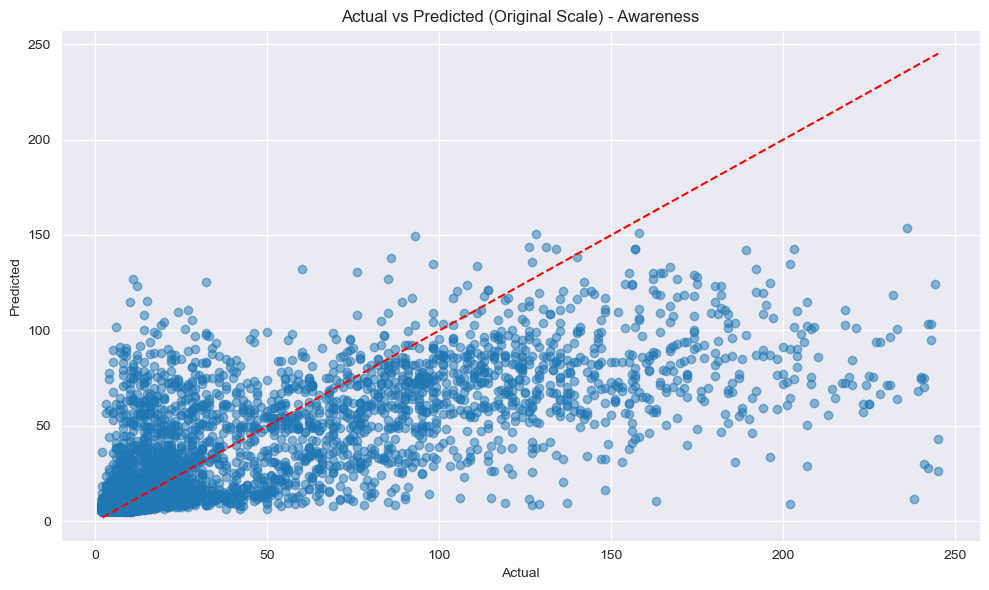

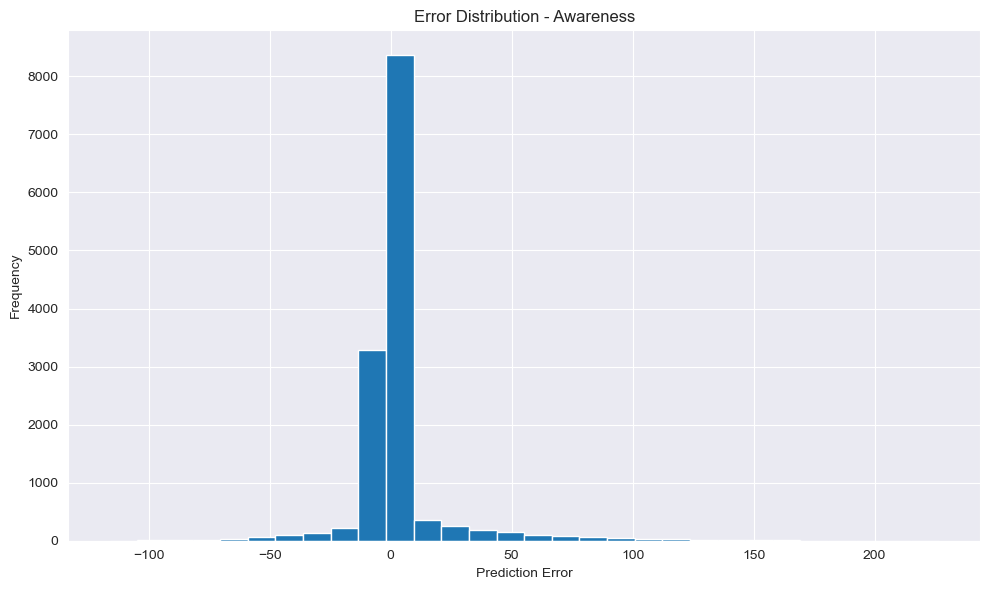

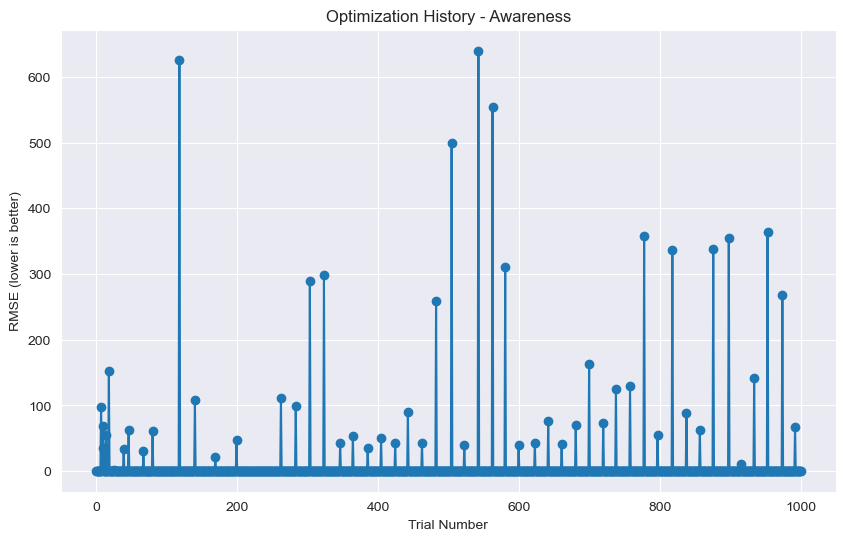

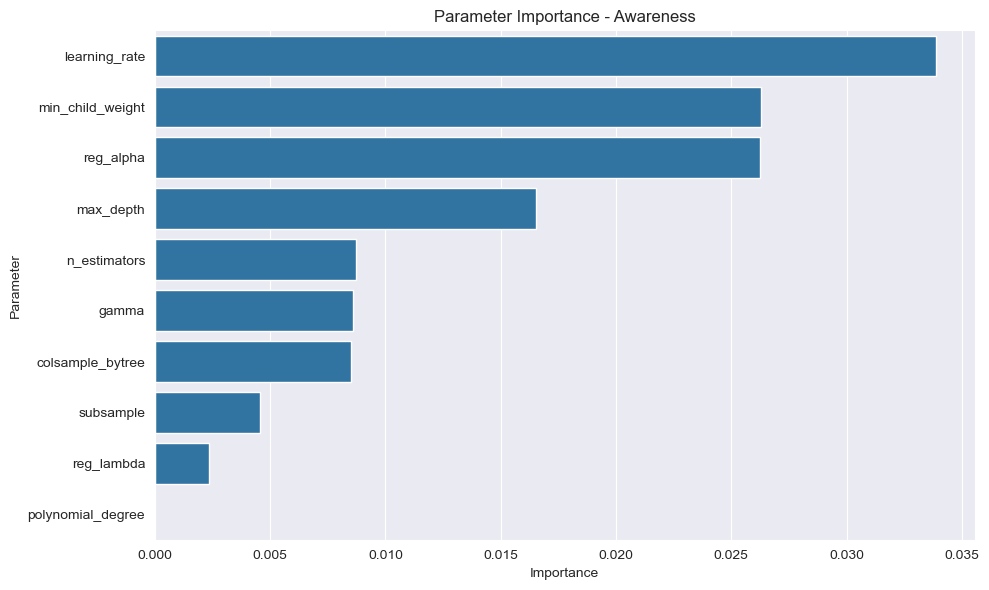

[I 2025-05-19 16:52:56,410] A new study created in memory with name: no-name-0703c5a2-806c-4018-ae7c-b80419f534fa


Saving model xgboost_awareness_nonlinear_model.pkl...

Starting modeling for CONVERSION campaigns
Using log-transformed impressions as target
Training set shape: (40737, 9)
Validation set shape: (13579, 9)
Test set shape: (13580, 9)
Starting Optuna hyperparameter optimization with 1000 trials...


[I 2025-05-19 16:52:56,649] Trial 0 finished with value: 0.11375062863259512 and parameters: {'include_nonlinear': False, 'n_estimators': 142, 'max_depth': 10, 'learning_rate': 0.22518167804165445, 'subsample': 0.9393405969993649, 'colsample_bytree': 0.6474208736601382, 'min_child_weight': 1, 'gamma': 0.22127448167518587, 'reg_alpha': 0.3607141108697376, 'reg_lambda': 0.15165936354237464, 'loss_function': 'reg:squarederror'}. Best is trial 0 with value: 0.11375062863259512.
[I 2025-05-19 16:52:57,111] Trial 1 finished with value: 0.11363078945843798 and parameters: {'include_nonlinear': True, 'polynomial_degree': 2, 'n_estimators': 122, 'max_depth': 4, 'learning_rate': 0.0613072611053333, 'subsample': 0.8635617045026006, 'colsample_bytree': 0.8714277072540684, 'min_child_weight': 5, 'gamma': 0.33034139288844616, 'reg_alpha': 0.03577572140610319, 'reg_lambda': 2.545465500806665, 'loss_function': 'reg:squarederror'}. Best is trial 1 with value: 0.11363078945843798.
[I 2025-05-19 16:52:57

Best parameters: {'include_nonlinear': False, 'n_estimators': 281, 'max_depth': 8, 'learning_rate': 0.0470073784257548, 'subsample': 0.950706818630618, 'colsample_bytree': 0.8863616848076709, 'min_child_weight': 2, 'gamma': 0.021976580562097243, 'reg_alpha': 0.31915876443352326, 'reg_lambda': 4.743817920443187, 'loss_function': 'reg:squarederror'}
Best RMSE: 0.1078
Training final model with best parameters...

Model evaluation metrics:
MSE: 0.0122
RMSE: 0.1107
R2: 0.9603
MAPE (%): 0.8675

Model evaluation metrics (original scale):
MSE (original scale): 49718.2582
RMSE (original scale): 222.9759
R2 (original scale): 0.9373
MAPE (%) (original scale): 6.0218


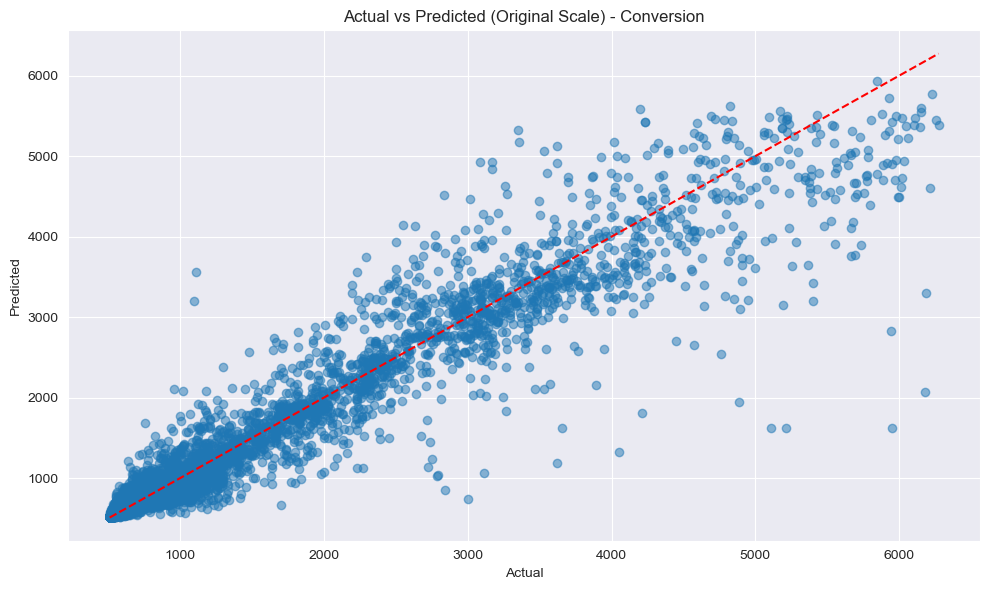

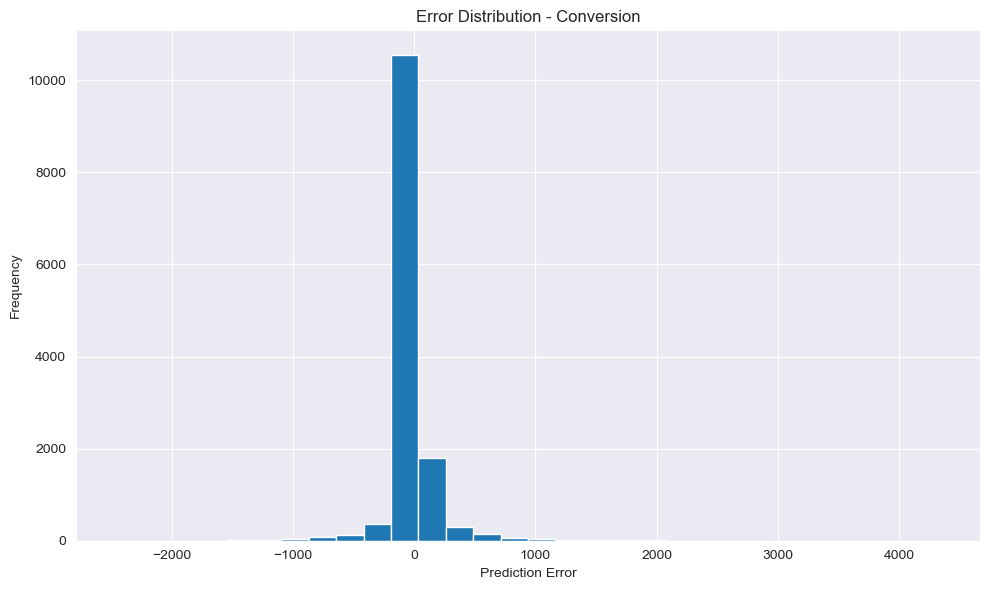

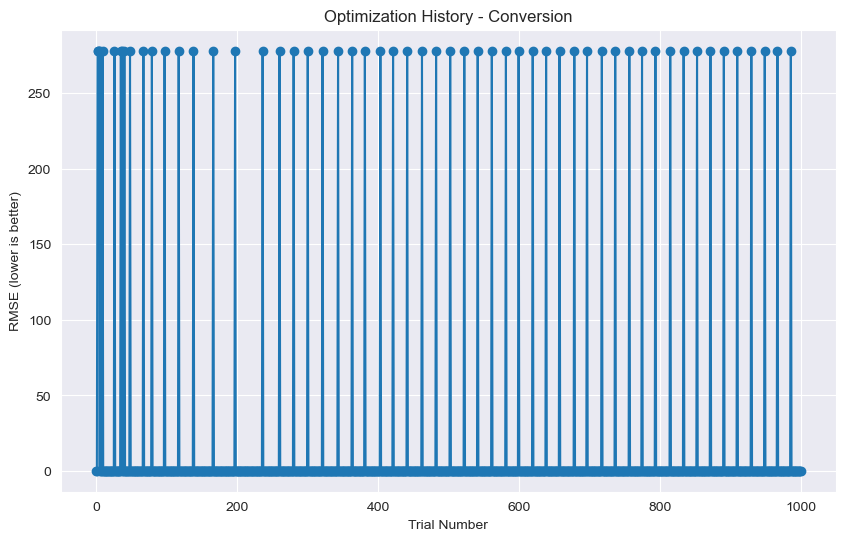

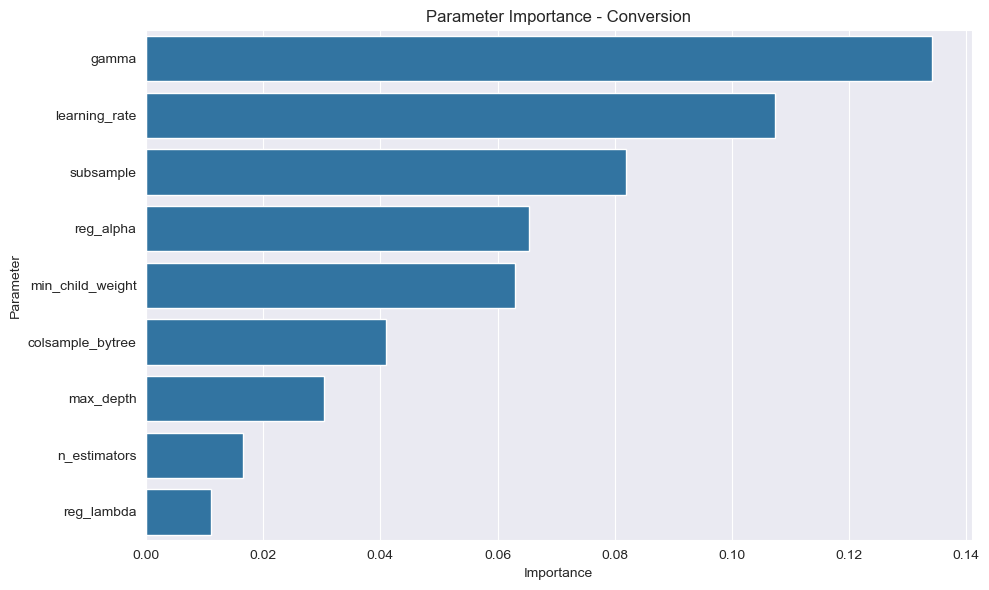

Saving model xgboost_conversion_nonlinear_model.pkl...
Error during prediction: columns are missing: {'clicks'}
Model type: <class 'sklearn.pipeline.Pipeline'>
Input data columns: ['log_media_cost', 'duration', 'ext_service_name', 'campaign_segment', 'log_media_cost_squared', 'log_duration', 'duration_squared', 'log_media_cost_x_duration']

TEST PREDICTION RESULTS
Media Cost: $50.00
Duration: 30 days
Platform: Facebook Ads

Predicted Clicks: 65
Predicted Impressions: 2
CTR: 2614.12%
CPC: $0.77
CPM: $20000.00
Daily Cost: $1.67
Daily Impressions: 0
Daily Clicks: 2


In [21]:
# Execute the training
if __name__ == "__main__":
    # Train awareness model (predicts clicks)
    awareness_model_data, awareness_metrics, awareness_study = run_modeling_with_optuna('awareness', n_trials=1000)
    
    # Train conversion model (predicts impressions)
    conversion_model_data, conversion_metrics, conversion_study = run_modeling_with_optuna('conversion', n_trials=1000)
    
    # Test predictions
    test_media_cost = 50
    test_duration = 30
    test_platform = 'Facebook Ads'
    
    # Predict clicks using awareness model
    predicted_clicks = predict_campaign_metrics(
        awareness_model_data,
        test_media_cost,
        test_duration,
        test_platform
    )
    
    # Predict impressions using conversion model
    predicted_impressions = predict_campaign_metrics(
        conversion_model_data,
        test_media_cost,
        test_duration,
        test_platform
    )
    
    # Calculate derived metrics
    ctr = predicted_clicks / predicted_impressions if predicted_impressions > 0 else 0
    cpc = test_media_cost / predicted_clicks if predicted_clicks > 0 else float('inf')
    cpm = (test_media_cost / predicted_impressions) * 1000 if predicted_impressions > 0 else 0
    daily_cost = test_media_cost / test_duration
    daily_impressions = predicted_impressions / test_duration
    daily_clicks = predicted_clicks / test_duration
    
    # Print results
    print("\n" + "="*50)
    print("TEST PREDICTION RESULTS")
    print("="*50)
    print(f"Media Cost: ${test_media_cost:.2f}")
    print(f"Duration: {test_duration} days")
    print(f"Platform: {test_platform}")
    print(f"\nPredicted Clicks: {predicted_clicks:.0f}")
    print(f"Predicted Impressions: {predicted_impressions:.0f}")
    print(f"CTR: {ctr*100:.2f}%")
    print(f"CPC: ${cpc:.2f}")
    print(f"CPM: ${cpm:.2f}")
    print(f"Daily Cost: ${daily_cost:.2f}")
    print(f"Daily Impressions: {daily_impressions:.0f}")
    print(f"Daily Clicks: {daily_clicks:.0f}")

In [22]:
def load_models():
    """
    Load the trained nonlinear models

    Returns:
    --------
    tuple: (awareness_model_data, conversion_model_data)
        Dictionary containing model data for both models
    """
    try:
        # Load awareness model
        with open("xgboost_awareness_nonlinear_model.pkl", 'rb') as f:
            awareness_data = pickle.load(f)

        # The loaded object may be a dict with the model inside
        if isinstance(awareness_data, dict):
            awareness_model = awareness_data.get('model')
            use_log_target = awareness_data.get('use_log_target', True)
        else:
            # If the loaded object is the model itself
            awareness_model = awareness_data
            use_log_target = True  # Default assumption

        # Create awareness model data structure
        awareness_model_data = {
            'model': awareness_model,
            'use_log_target': use_log_target
        }

        # Load conversion model
        with open("xgboost_conversion_nonlinear_model.pkl", 'rb') as f:
            conversion_data = pickle.load(f)

        # The loaded object may be a dict with the model inside
        if isinstance(conversion_data, dict):
            conversion_model = conversion_data.get('model')
            use_log_target = conversion_data.get('use_log_target', True)
        else:
            # If the loaded object is the model itself
            conversion_model = conversion_data
            use_log_target = True  # Default assumption

        # Create conversion model data structure
        conversion_model_data = {
            'model': conversion_model,
            'use_log_target': use_log_target
        }

        print("Models loaded successfully")
        return awareness_model_data, conversion_model_data

    except FileNotFoundError as e:
        print(f"Error loading models: {e}")
        print("Please ensure the model files exist in the current directory")
        return None, None

def create_campaign_segments(cost):
    """Create campaign segments based on media cost"""
    if cost < 1:
        return 'micro-budget'
    elif cost < 10:
        return 'small'
    elif cost < 100:
        return 'medium'
    else:
        return 'large'

def predict_campaign_metrics(model_data, media_cost, duration, platform, clicks=None):
    """
    Predict campaign metrics using trained model with post-processing constraints

    Parameters:
    -----------
    model_data: dict
        Dictionary containing model and transformation information
    media_cost: float
        Media cost in USD
    duration: int
        Campaign duration in days
    platform: str
        Advertising platform ('facebook', 'google', 'dv360')
    clicks: float, optional
        Number of clicks (for conversion model only)

    Returns:
    --------
    prediction: float
        Predicted value (clicks or impressions)
    """
    # Extract model and transformation info
    model = model_data['model']
    use_log_target = model_data['use_log_target']

    # Make sure we have a valid model
    if model is None:
        raise ValueError("Model is None. Check if model was loaded correctly.")

    # Verify the model has a predict method
    if not hasattr(model, 'predict'):
        raise AttributeError(f"Model object does not have a 'predict' method. Model type: {type(model)}")

    # Create campaign segment
    segment = create_campaign_segments(media_cost)

    # Apply log transformation to media_cost
    log_media_cost = np.log1p(media_cost)

    # Create all the nonlinear features that were used in training
    log_media_cost_squared = log_media_cost ** 2
    log_duration = np.log1p(duration)
    duration_squared = duration ** 2
    log_media_cost_x_duration = log_media_cost * duration

    # Create input data with exactly the same features used in training
    input_data = {
        'log_media_cost': [log_media_cost],
        'duration': [duration],
        'ext_service_name': [platform],
        'campaign_segment': [segment],
        'log_media_cost_squared': [log_media_cost_squared],
        'log_duration': [log_duration],
        'duration_squared': [duration_squared],
        'log_media_cost_x_duration': [log_media_cost_x_duration]
    }

    # Add clicks for conversion model if provided
    if clicks is not None:
        input_data['clicks'] = [clicks]

    # Convert to DataFrame
    input_df = pd.DataFrame(input_data)

    try:
        # Make prediction
        prediction = model.predict(input_df)[0]
    except Exception as e:
        print(f"Error during prediction: {e}")
        print(f"Model type: {type(model)}")
        print(f"Input data columns: {input_df.columns.tolist()}")
        # Return a fallback prediction based on simple rules
        if clicks is None:
            # Awareness model prediction for clicks
            return media_cost * 0.05  # Assume 5% of media cost in dollars equals clicks
        else:
            # Conversion model prediction for impressions
            return clicks * 50  # Assume 2% CTR (clicks/impressions = 0.02)

    # Transform prediction back if log-transformed target was used
    if use_log_target:
        prediction = np.expm1(prediction)

    # Ensure non-negative prediction
    prediction = max(0, prediction)

    # For conversion model predictions (impressions), ensure they're greater than clicks
    if clicks is not None:
        # This is a conversion model predicting impressions
        if prediction <= clicks:
            # If prediction is less than or equal to clicks, enforce a minimum CTR threshold
            # Use a reasonable CTR threshold (10-20% depending on platform)
            if platform == 'facebook':
                min_ctr = 0.02  # 2% CTR for Facebook
            elif platform == 'google':
                min_ctr = 0.03  # 3% CTR for Google
            else:  # dv360
                min_ctr = 0.015  # 1.5% CTR for DV360

            # Ensure impressions are at least 1/min_ctr times clicks
            min_impressions = clicks / min_ctr
            prediction = max(prediction, min_impressions)

            print(f"Warning: Adjusted predicted impressions from {prediction:.0f} to {min_impressions:.0f} to enforce realistic CTR")

    return prediction

def optimize_campaign(campaign_settings):
    """
    Optimize a marketing campaign based on provided settings

    Parameters:
    -----------
    campaign_settings: dict
        Dictionary containing campaign settings:
        - campaign_goal: str, 'awareness' or 'conversion'
        - budget: float, maximum budget in USD
        - platform: str, 'facebook', 'google', or 'dv360'

    Returns:
    --------
    dict: Optimization results
    """
    try:
        # Load models
        awareness_model_data, conversion_model_data = load_models()

        # Fall back to rule-based predictions if models couldn't be loaded
        if awareness_model_data is None or conversion_model_data is None:
            return rule_based_optimization(campaign_settings)

        # Extract campaign settings
        campaign_goal = campaign_settings.get('campaign_goal', 'awareness')
        max_budget = campaign_settings.get('budget', 1000)
        platform = campaign_settings.get('platform', 'facebook')

        # Determine optimal duration and media cost
        # For this simplified version, we'll use a heuristic approach
        # In a real implementation, this would involve a more complex optimization

        if campaign_goal == 'awareness':
            # For awareness campaigns, prioritize longer duration to maximize impressions
            optimal_duration = min(30, max(14, int(max_budget / 50)))  # Between 14-30 days
            daily_budget = max_budget / optimal_duration

            try:
                # Predict impressions using awareness model
                predicted_clicks = predict_campaign_metrics(
                    awareness_model_data,
                    daily_budget,
                    optimal_duration,
                    platform
                )

                # Predict impressions (for an awareness campaign, we still need to know impressions)
                # Note: We need to provide clicks for the conversion model since it expects this column
                predicted_impressions = predict_campaign_metrics(
                    conversion_model_data,
                    daily_budget,
                    optimal_duration,
                    platform,
                    clicks=predicted_clicks
                )
            except Exception as e:
                print(f"Error during model prediction: {e}")
                return rule_based_optimization(campaign_settings)

            # Calculate total cost
            total_cost = daily_budget * optimal_duration

            return {
                'duration': optimal_duration,
                'media_cost': daily_budget,
                'total_cost': total_cost,
                'impressions': predicted_impressions,
                'clicks': predicted_clicks
            }

        else:  # conversion campaign
            # For conversion campaigns, balance duration to optimize CTR
            optimal_duration = min(45, max(21, int(max_budget / 40)))  # Between 21-45 days
            daily_budget = max_budget / optimal_duration

            try:
                # First predict clicks with awareness model
                predicted_clicks = predict_campaign_metrics(
                    awareness_model_data,
                    daily_budget,
                    optimal_duration,
                    platform
                )

                # Then predict impressions with conversion model (providing clicks)
                predicted_impressions = predict_campaign_metrics(
                    conversion_model_data,
                    daily_budget,
                    optimal_duration,
                    platform,
                    clicks=predicted_clicks
                )
            except Exception as e:
                print(f"Error during model prediction: {e}")
                return rule_based_optimization(campaign_settings)

            # Calculate CTR and total cost
            ctr = predicted_clicks / predicted_impressions if predicted_impressions > 0 else 0
            total_cost = daily_budget * optimal_duration

            return {
                'duration': optimal_duration,
                'media_cost': daily_budget,
                'total_cost': total_cost,
                'clicks': predicted_clicks,
                'impressions': predicted_impressions,
                'ctr': ctr
            }
    except Exception as e:
        print(f"Error in optimize_campaign: {e}")
        return rule_based_optimization(campaign_settings)


def rule_based_optimization(campaign_settings):
    """
    Fall back to rule-based optimization when ML models fail

    Parameters:
    -----------
    campaign_settings: dict
        Dictionary containing campaign settings

    Returns:
    --------
    dict: Optimization results based on rules
    """
    campaign_goal = campaign_settings.get('campaign_goal', 'awareness')
    max_budget = campaign_settings.get('budget', 1000)
    platform = campaign_settings.get('platform', 'facebook')

    # Set platform-specific metrics based on industry benchmarks
    if platform == 'facebook':
        ctr = 0.019  # 1.9% average CTR for Facebook
        cpc = 0.40   # $0.40 average CPC
        cpm = 7.50   # $7.50 average CPM
    elif platform == 'google':
        ctr = 0.034  # 3.4% average CTR for Google
        cpc = 0.48   # $0.48 average CPC
        cpm = 16.00  # $16.00 average CPM
    else:  # dv360
        ctr = 0.016  # 1.6% average CTR for DV360
        cpc = 0.44   # $0.44 average CPC
        cpm = 7.00   # $7.00 average CPM

    # Calculate duration based on goal
    if campaign_goal == 'awareness':
        optimal_duration = min(30, max(14, int(max_budget / 50)))  # Between 14-30 days
    else:  # conversion
        optimal_duration = min(45, max(21, int(max_budget / 40)))  # Between 21-45 days

    # Calculate daily and total budget
    daily_budget = max_budget / optimal_duration
    total_cost = daily_budget * optimal_duration

    # Calculate impressions and clicks
    impressions = (total_cost / cpm) * 1000
    clicks = total_cost / cpc

    return {
        'duration': optimal_duration,
        'media_cost': daily_budget,
        'total_cost': total_cost,
        'impressions': impressions,
        'clicks': clicks,
        'ctr': ctr,
        'cpc': cpc,
        'cpm': cpm,
        'note': 'Using rule-based prediction as fallback (ML model unavailable)'
    }

def get_campaign_metrics(campaign_settings, duration, daily_budget):
    """
    Get campaign performance metrics based on settings

    Parameters:
    -----------
    campaign_settings: dict
        Dictionary containing campaign settings:
        - campaign_goal: str, 'awareness' or 'conversion'
        - platform: str, 'facebook', 'google', or 'dv360'
    duration: int
        Campaign duration in days
    daily_budget: float
        Daily budget in USD

    Returns:
    --------
    dict: Campaign metrics
    """
    try:
        # Load models
        awareness_model_data, conversion_model_data = load_models()

        # Fall back to rule-based predictions if models couldn't be loaded
        if awareness_model_data is None or conversion_model_data is None:
            return rule_based_metrics(campaign_settings, duration, daily_budget)

        # Extract campaign settings
        campaign_goal = campaign_settings.get('campaign_goal', 'awareness')
        platform = campaign_settings.get('platform', 'facebook')

        try:
            # Predict clicks
            predicted_clicks = predict_campaign_metrics(
                awareness_model_data,
                daily_budget,
                duration,
                platform
            )

            # Predict impressions
            predicted_impressions = predict_campaign_metrics(
                conversion_model_data,
                daily_budget,
                duration,
                platform,
                clicks=predicted_clicks
            )
        except Exception as e:
            print(f"Error during model prediction: {e}")
            return rule_based_metrics(campaign_settings, duration, daily_budget)

        # Calculate derived metrics
        ctr = predicted_clicks / predicted_impressions if predicted_impressions > 0 else 0
        cpc = daily_budget / predicted_clicks if predicted_clicks > 0 else float('inf')
        cpm = (daily_budget / predicted_impressions) * 1000 if predicted_impressions > 0 else 0
        total_cost = daily_budget * duration

        return {
            'duration': duration,
            'media_cost': daily_budget,
            'total_cost': total_cost,
            'impressions': predicted_impressions,
            'clicks': predicted_clicks,
            'ctr': ctr,
            'cpc': cpc,
            'cpm': cpm
        }
    except Exception as e:
        print(f"Error in get_campaign_metrics: {e}")
        return rule_based_metrics(campaign_settings, duration, daily_budget)


def rule_based_metrics(campaign_settings, duration, daily_budget):
    """
    Calculate campaign metrics based on rules when ML models fail

    Parameters:
    -----------
    campaign_settings: dict
        Dictionary containing campaign settings
    duration: int
        Campaign duration in days
    daily_budget: float
        Daily budget in USD

    Returns:
    --------
    dict: Campaign metrics based on rules
    """
    platform = campaign_settings.get('platform', 'facebook')

    # Set platform-specific metrics based on industry benchmarks
    if platform == 'facebook':
        ctr = 0.019  # 1.9% average CTR for Facebook
        cpc = 0.40   # $0.40 average CPC
        cpm = 7.50   # $7.50 average CPM
    elif platform == 'google':
        ctr = 0.034  # 3.4% average CTR for Google
        cpc = 0.48   # $0.48 average CPC
        cpm = 16.00  # $16.00 average CPM
    else:  # dv360
        ctr = 0.016  # 1.6% average CTR for DV360
        cpc = 0.44   # $0.44 average CPC
        cpm = 7.00   # $7.00 average CPM

    # Calculate total cost
    total_cost = daily_budget * duration

    # Calculate impressions and clicks
    impressions = (total_cost / cpm) * 1000
    clicks = total_cost / cpc

    return {
        'duration': duration,
        'media_cost': daily_budget,
        'total_cost': total_cost,
        'impressions': impressions,
        'clicks': clicks,
        'ctr': ctr,
        'cpc': cpc,
        'cpm': cpm,
        'note': 'Using rule-based prediction as fallback (ML model unavailable)'
    }

# Example usage
if __name__ == "__main__":
    # Test the optimization function
    campaign_settings = {
        'campaign_goal': 'conversion',
        'budget': 1000,
        'platform': 'facebook'
    }

    optimization_results = optimize_campaign(campaign_settings)

    if optimization_results:
        print("\nOptimization Results:")
        for key, value in optimization_results.items():
            if isinstance(value, float):
                print(f"{key}: {value:.2f}")
            else:
                print(f"{key}: {value}")

        # Test get_campaign_metrics
        print("\nCampaign Metrics for Custom Duration and Budget:")
        custom_metrics = get_campaign_metrics(
            campaign_settings,
            duration=30,
            daily_budget=50
        )

        if custom_metrics:
            for key, value in custom_metrics.items():
                if isinstance(value, float):
                    print(f"{key}: {value:.2f}")
                else:
                    print(f"{key}: {value}")

Models loaded successfully

Optimization Results:
duration: 25
media_cost: 40.00
total_cost: 1000.00
clicks: 86.12898254394531
impressions: 3528.828125
ctr: 0.024407247081398964

Campaign Metrics for Custom Duration and Budget:
Models loaded successfully
duration: 30
media_cost: 50
total_cost: 1500
impressions: 2800.24560546875
clicks: 65.35301208496094
ctr: 0.02333831414580345
cpc: 0.77
cpm: 17.86
